In [27]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier



This notebook explore MLP on 5 features. 

In [63]:
#FIXME No physics weights implemented in the MLP clf. 

In [28]:
file = '/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EB3/pkls/1M_sample_periodA.pkl'
small_sample = pd.read_pickle(file)
small_sample_array = small_sample.to_numpy()
X = small_sample_array[:, :-1]
y = small_sample_array[:, -1]

In [29]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [46]:
n_features = 5
columns = [*small_sample.columns]
ntrk_idx = columns.index('jet_nTracks')
flat_pt_weight_idx = columns.index('flat_weight')
phys_weight_idx = columns.index('total_weight')

In [31]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

scaler.fit(X_train[:, :n_features])  
X_train[:, :n_features] = scaler.transform(X_train[:, :n_features])  

X_test[:, :n_features] = scaler.transform(X_test[:, :n_features])  


In [32]:
clf = MLPClassifier(solver='adam', alpha=1e-5, 
                    hidden_layer_sizes=(5, 2), random_state=42)
                    
clf.fit(X_train[:, :n_features], y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=42)

In [33]:
y_test_decisions = clf.predict_proba(X_test[:, :n_features])[:,1]

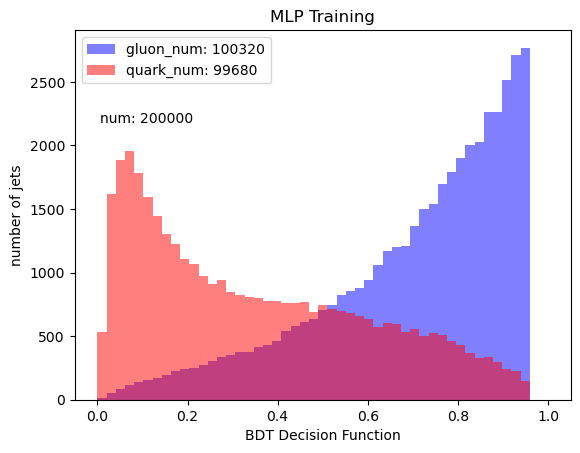

In [37]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(0, 1, 50)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test[y_test_gluon_id][:, phys_weight_idx], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test[y_test_quark_id][:, phys_weight_idx], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"MLP Training")
plt.savefig("MLP_Training.png", dpi=300)
plt.show()

In [39]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC')
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


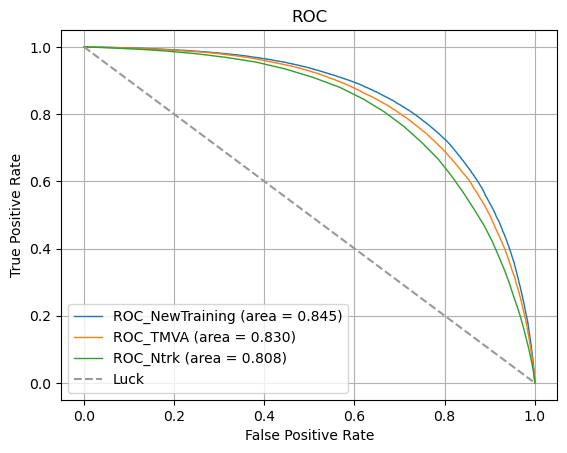

In [40]:
Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test[:,-4] , y_ntrk=X_test[:,2], X_weight=X_test[:, phys_weight_idx], features="Only Ntrk")

In [41]:
import pickle
filename = './MLP_classifier.model'
pickle.dump(clf, open(filename, 'wb'))

# Apply to data with eta label to show Forward/Central

## Read data

In [42]:
data_path = '/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EPEML/pkls_etalabel/all_JZs_format2.pkl'
with open(data_path, 'rb') as f:
    data = pickle.load(f)

columns = [*data['JZ4'].columns]
n_features = 5


In [43]:
empty_list = []
for key, data_JZ in tqdm(data.items()):
    empty_list.append(data_JZ.drop(columns=['event']))
pd_all = pd.concat(empty_list)

100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


In [55]:
pd_array = pd_all.to_numpy()
jets_array = pd_array.reshape((int(len(pd_array)*2), -1))
assert jets_array.shape[-1] == 10 

n_test = len(y_test)
np.random.seed(42)
rdn_choice =  np.random.choice(np.arange(len(jets_array)), n_test)
jets_array = jets_array[rdn_choice]

In [56]:
jets_array_transformed = jets_array.copy()
jets_array_transformed[:, :n_features] = scaler.transform(jets_array_transformed[:, :n_features])  

In [57]:
y_mc16A = clf.predict_proba(jets_array_transformed[:, :n_features])[:,1]

## Plot new response

### Inclusive Quark vs Gluon

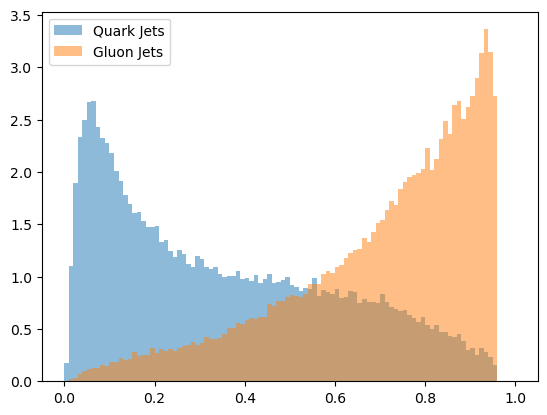

In [58]:
bdt_bins = np.linspace(0, 1, 101)
quark_idx = np.where(jets_array[:, -1] ==0)[0]
gluon_idx = np.where(jets_array[:, -1] ==1)[0]

fig, ax = plt.subplots()
ax.hist(y_mc16A[quark_idx], weights=jets_array[quark_idx,-3], bins=  bdt_bins, alpha = 0.5,label='Quark Jets', density=True)
ax.hist(y_mc16A[gluon_idx], weights=jets_array[gluon_idx,-3], bins=  bdt_bins, alpha = 0.5,label='Gluon Jets', density=True)
ax.legend()
plt.show()

### Quark vs Gluon in pt bins

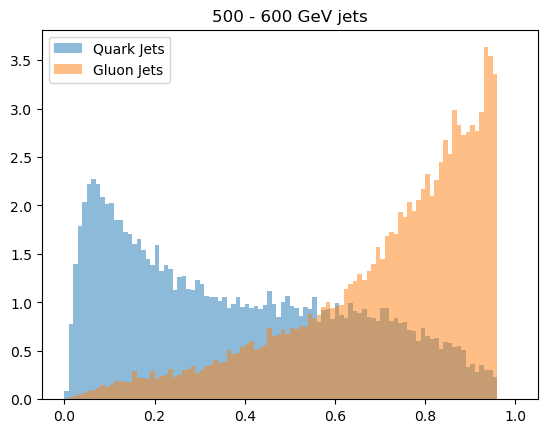

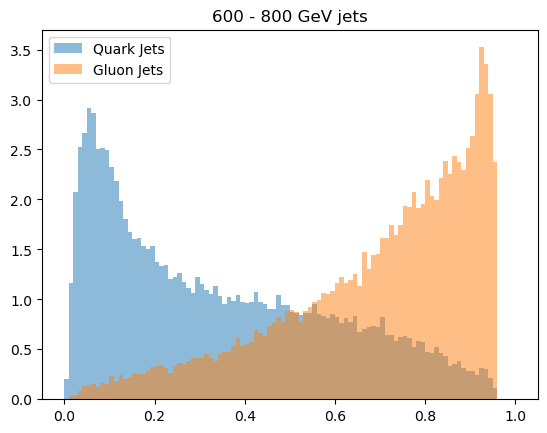

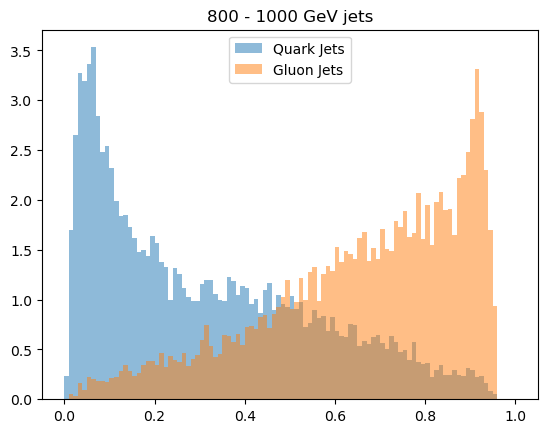

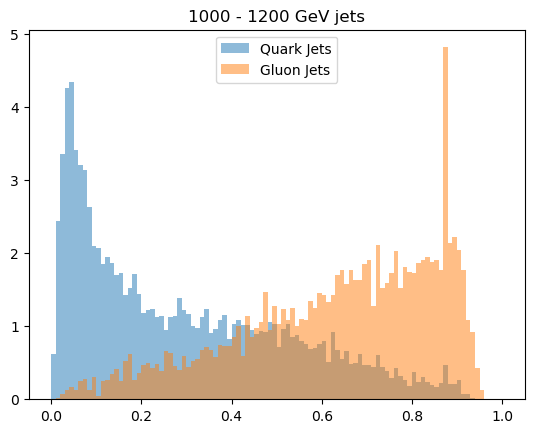

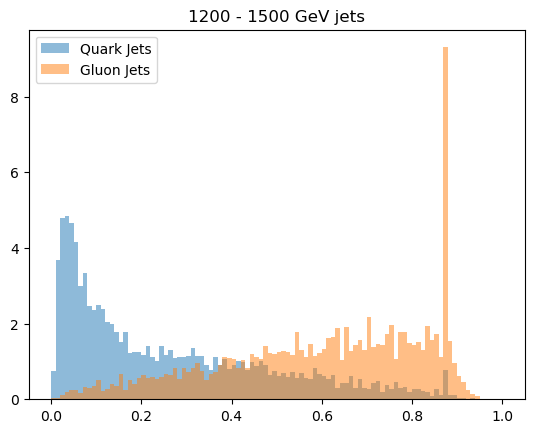

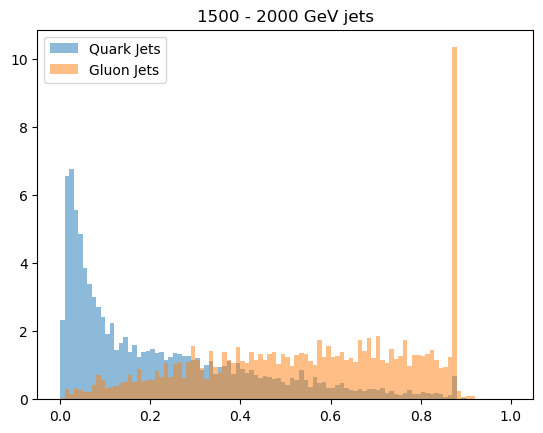

In [59]:
label_ptrange = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
pt_binned_jets_idx = np.digitize(jets_array[:,0], bins=label_ptrange)
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = jets_array[jets_at_pt_idx]
    gluon_idx = np.where(jets_at_pt[:, -1] ==1)[0]
    quark_idx = np.where(jets_at_pt[:, -1] ==0)[0]
    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][quark_idx], weights=jets_at_pt[quark_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Quark Jets', density = True)
    ax.hist(y_mc16A[jets_at_pt_idx][gluon_idx], weights=jets_at_pt[gluon_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Gluon Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()

### Inclusive Forward vs Central

[]

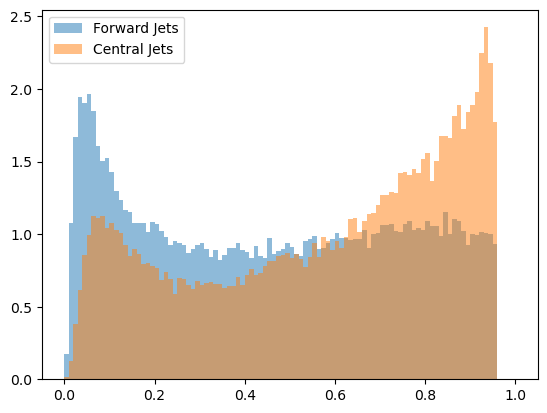

In [60]:
forward_idx = np.where(jets_array[:, -2] ==1)[0]
central_idx = np.where(jets_array[:, -2] ==0)[0]
fig, ax = plt.subplots()
ax.hist(y_mc16A[forward_idx], weights=jets_array[forward_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Forward Jets', density = True)
ax.hist(y_mc16A[central_idx], weights=jets_array[central_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Central Jets', density = True)
ax.legend()
plt.plot()

### Forward vs Central in pt bins

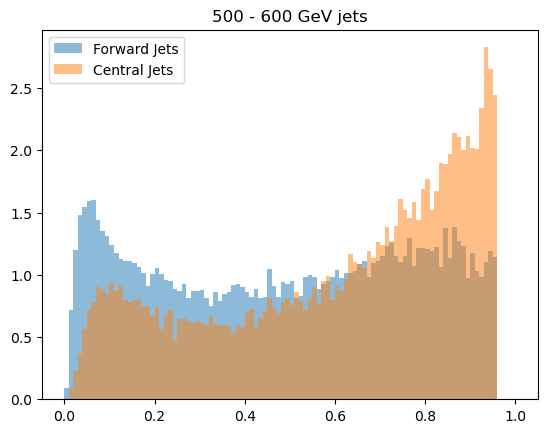

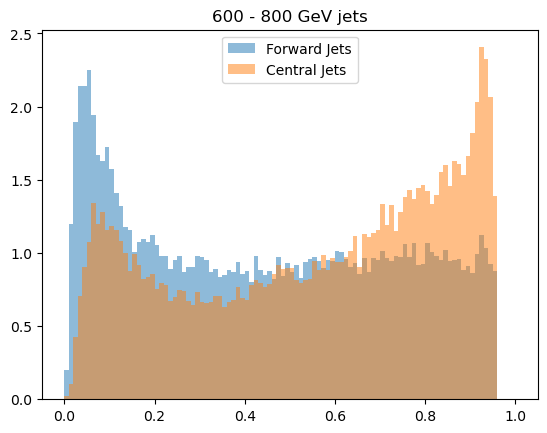

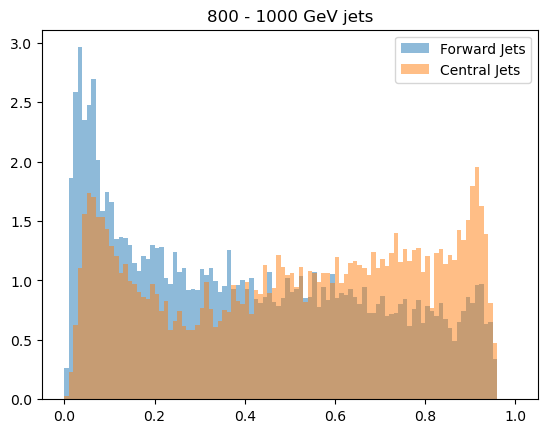

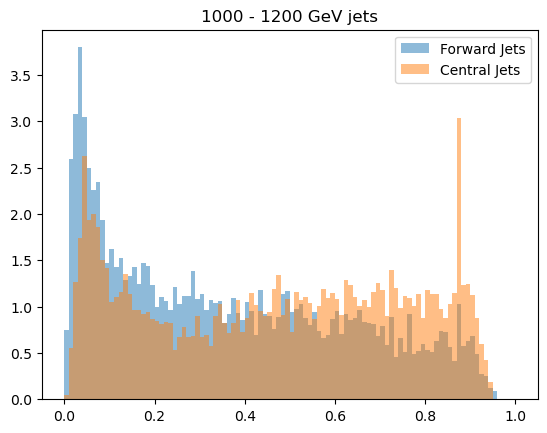

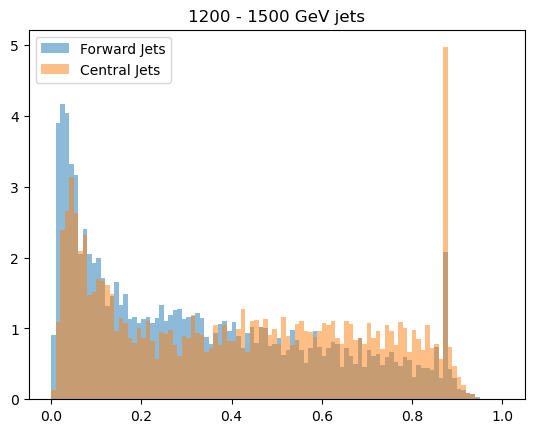

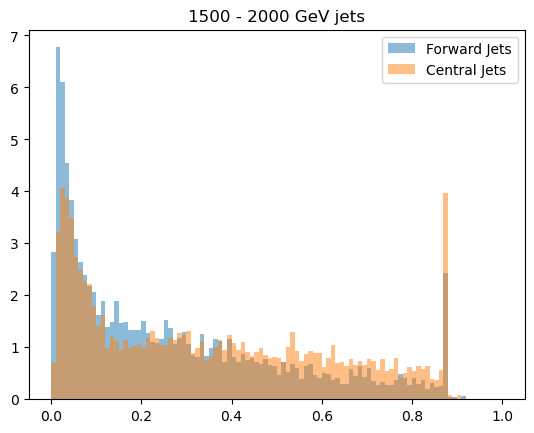

In [61]:
label_ptrange = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
pt_binned_jets_idx = np.digitize(jets_array[:,0], bins=label_ptrange)
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = jets_array[jets_at_pt_idx]
    forward_idx = np.where(jets_at_pt[:, -2] ==1)[0]
    central_idx = np.where(jets_at_pt[:, -2] ==0)[0]
    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx], weights=jets_at_pt[forward_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Forward Jets', density = True)
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx], weights=jets_at_pt[central_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Central Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()

### Forward/Central Q/G components

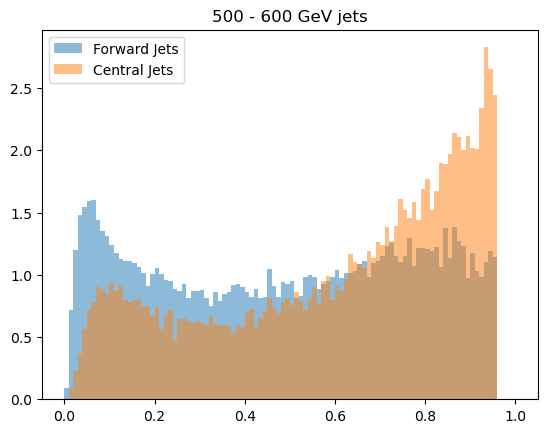

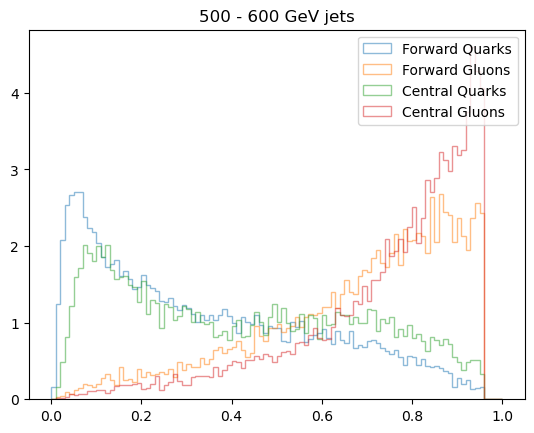

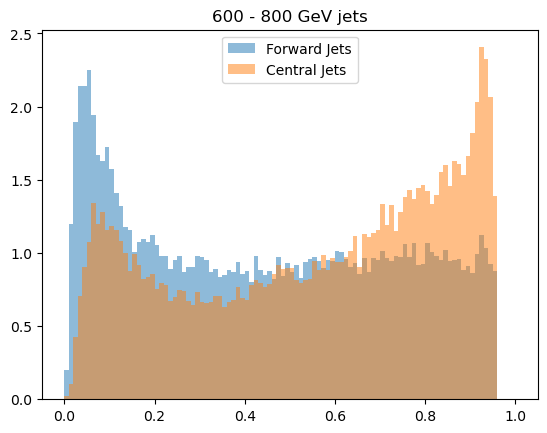

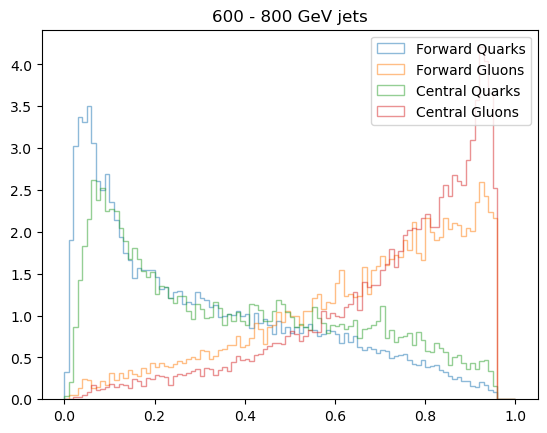

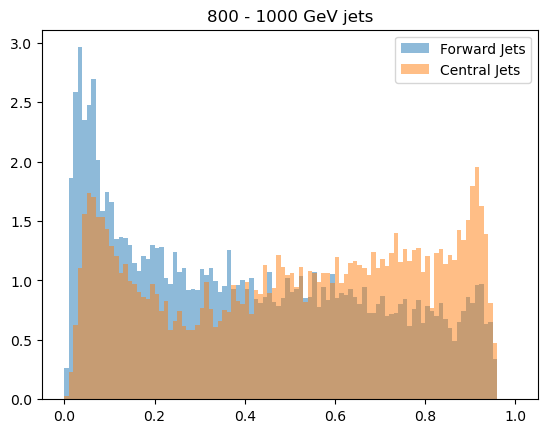

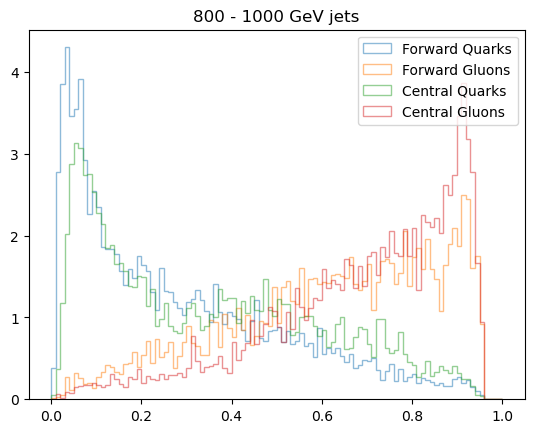

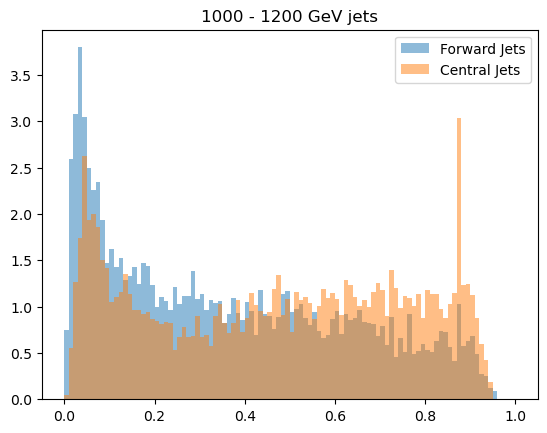

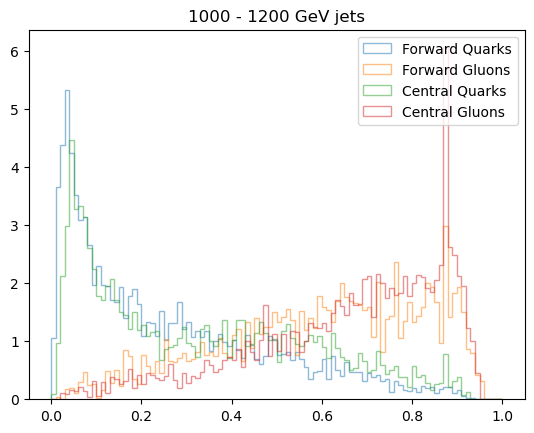

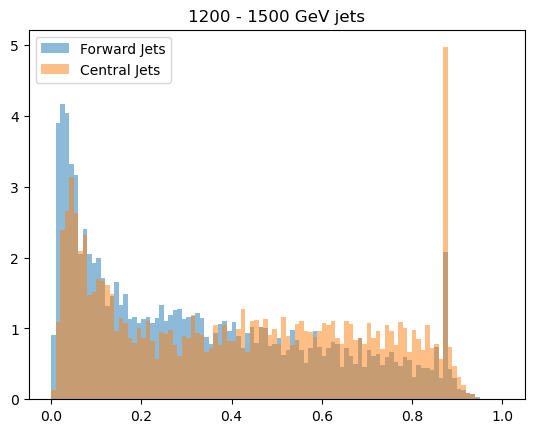

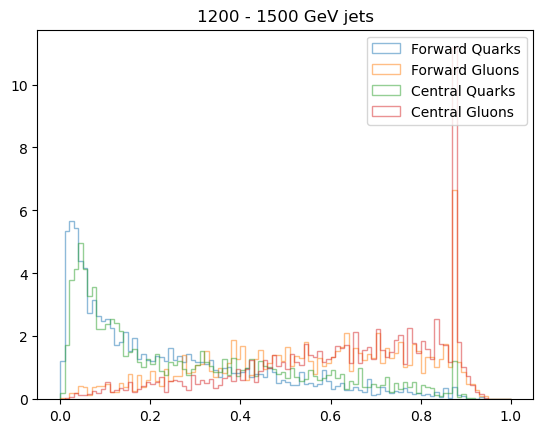

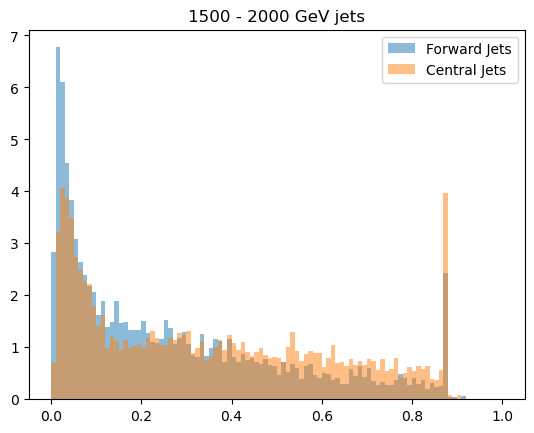

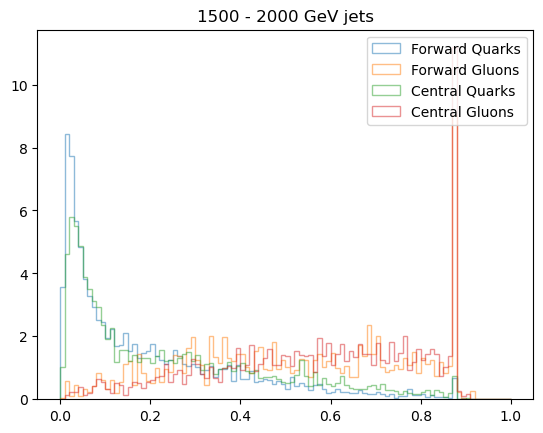

In [62]:
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = jets_array[jets_at_pt_idx]
    forward_idx = np.where(jets_at_pt[:, -2] ==1)[0]
    central_idx = np.where(jets_at_pt[:, -2] ==0)[0]

    forward_jets = jets_at_pt[forward_idx]
    central_jets = jets_at_pt[central_idx]


    forward_quark_idx = np.where(forward_jets[:, -1] == 0)[0]
    forward_gluon_idx = np.where(forward_jets[:, -1] == 1)[0]
    central_quark_idx = np.where(central_jets[:, -1] == 0)[0]
    central_gluon_idx = np.where(central_jets[:, -1] == 1)[0]

    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx], weights=forward_jets[:, -3], bins =  bdt_bins, alpha = 0.5, label='Forward Jets', density = True)
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx], weights=central_jets[:, -3], bins =  bdt_bins, alpha = 0.5, label='Central Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()


    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx][forward_quark_idx], weights=forward_jets[:, -3][forward_quark_idx], bins =  bdt_bins, alpha = 0.5, label='Forward Quarks', density = True, histtype='step')
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx][forward_gluon_idx], weights=forward_jets[:, -3][forward_gluon_idx], bins =  bdt_bins, alpha = 0.5, label='Forward Gluons', density = True, histtype='step')
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx][central_quark_idx], weights=central_jets[:, -3][central_quark_idx], bins =  bdt_bins, alpha = 0.5, label='Central Quarks', density = True, histtype='step')
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx][central_gluon_idx], weights=central_jets[:, -3][central_gluon_idx], bins =  bdt_bins, alpha = 0.5, label='Central Gluons', density = True, histtype='step')
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()
